### <span style="color:#EEE8AA"> Chargement des librairies </span>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.pipeline import Pipeline


### <span style="color:#EEE8AA"> Chargement des données </span>

In [255]:
df = pd.read_csv(r'mo-sef-applied-ml/data/train_validation_prepared.csv')
test = pd.read_csv(r'mo-sef-applied-ml/data/test_prepared.csv')

### <span style="color:#EEE8AA"> Définitions et sélection des variables  </span>

In [256]:
X = df.drop(columns=['id','date', 'cheveux', 'age', 'exp', 'salaire', 'sexe', 'diplome', 'specialite', 'note', 'dispo', 
                     'embauche', 
                     #'cheveux_imputed_mode', 'sexe_imputed_mode', 'diplome_imputed_mode', 'specialite_imputed_mode', 'dispo_imputed_mode',
                     'cheveux_imputed_missing', 'sexe_imputed_missing', 'diplome_imputed_missing', 'specialite_imputed_missing', 'dispo_imputed_missing'  ])  # On enlève les colonnes non-utiles pour la modélisation
y = df['embauche'] # La target

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [258]:
X_train.columns

Index(['age_imputed_mean', 'exp_imputed_mean', 'salaire_imputed_mean',
       'note_imputed_mean', 'age_imputed_regression', 'exp_imputed_regression',
       'salaire_imputed_regression', 'note_imputed_regression',
       'diplome_imputed_missing_encoded', 'sexe_imputed_missing_encoded',
       'dispo_imputed_missing_encoded', 'cheveux_imputed_missing_blond',
       'cheveux_imputed_missing_brun', 'cheveux_imputed_missing_chatain',
       'cheveux_imputed_missing_roux',
       'specialite_imputed_missing_archeologie',
       'specialite_imputed_missing_detective',
       'specialite_imputed_missing_forage',
       'specialite_imputed_missing_geologie'],
      dtype='object')

On a beaucoup de variables, on va essayer d'en selectionner les plus pertinentes, au vu d'indicateurs statistiqes

#### <span style="color:#EEE8AA"> VIF  </span>

In [259]:
# Entre numériques
# Ajout de la constante
X_vif = add_constant(X_train[['age_imputed_mean', 'exp_imputed_regression', 'salaire_imputed_regression', 'note_imputed_regression']])

# Calcul
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print(vif_data)

                     Variable         VIF
0                       const  158.693632
1            age_imputed_mean    1.000023
2      exp_imputed_regression    1.000437
3  salaire_imputed_regression    1.236659
4     note_imputed_regression    1.237074


In [260]:
# Entre catégorielles
# Ajout de la constante
X_vif = add_constant(X_train.drop(columns=['age_imputed_mean', 'exp_imputed_regression', 'salaire_imputed_regression', 'note_imputed_regression']
))

# Calcul
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]


print(vif_data)

                                  Variable         VIF
0                                    const  632.658857
1                         exp_imputed_mean    1.001696
2                     salaire_imputed_mean    1.856813
3                        note_imputed_mean    1.516983
4                   age_imputed_regression    1.000946
5          diplome_imputed_missing_encoded    2.944102
6             sexe_imputed_missing_encoded    1.478118
7            dispo_imputed_missing_encoded    1.889909
8            cheveux_imputed_missing_blond   44.244424
9             cheveux_imputed_missing_brun   44.323418
10         cheveux_imputed_missing_chatain   45.157440
11            cheveux_imputed_missing_roux   19.697826
12  specialite_imputed_missing_archeologie   15.344674
13    specialite_imputed_missing_detective   37.593286
14       specialite_imputed_missing_forage   38.209283
15     specialite_imputed_missing_geologie   55.742625


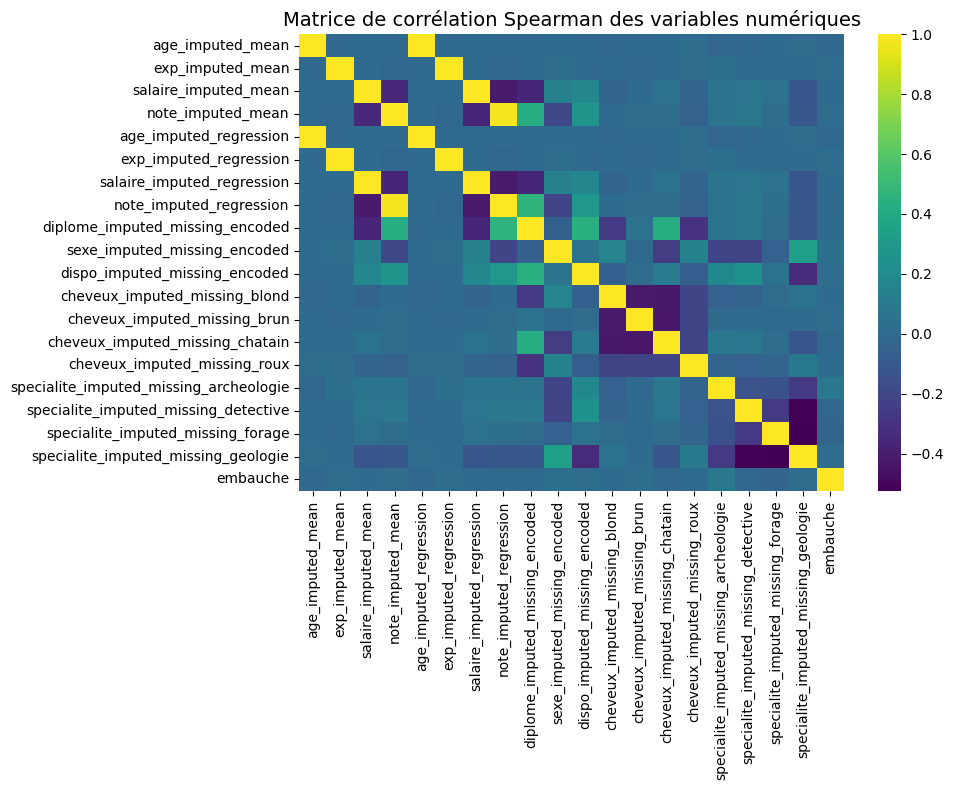

In [261]:
# matrice de corrélation avec la target
data_corr = pd.concat([X_train, y_train], axis=1)

# Matrice de corrélation Spearman
matrice_corr = data_corr.corr(method='spearman')

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrice_corr, cmap='viridis')
plt.title("Matrice de corrélation Spearman des variables numériques", fontsize=14)
plt.tight_layout()
plt.show()

Toutes des variables semblent avoir un VIF acceptable (inférieur à 5), on peut donc les garder toutes pour la modélisation. 
Elles sont aussi plus ou moins correlées entre elles individuellemt mais faiblement avec la target.
On va voir plusieurs modèles en les gradant toutes et plutard, developper des méthodes de sélection plus appropriées

### <span style="color:#EEE8AA"> Modèles  </span>

In [262]:
quanti_cols = [#'age_imputed_mean', 
               #'exp_imputed_mean', 
               #'salaire_imputed_mean',
               #'note_imputed_mean', 
               'age_imputed_regression', 
               #'exp_imputed_regression',
               #'salaire_imputed_regression', 
               #'note_imputed_regression'
               ]

quali_cols = [#'diplome_imputed_mode_encoded', 
              #'sexe_imputed_mode_encoded',
              #'dispo_imputed_mode_encoded', 
              #'cheveux_imputed_mode_brun',
              #'cheveux_imputed_mode_chatain', 
              #'cheveux_imputed_mode_roux',
              #'specialite_imputed_mode_detective', 
              #'specialite_imputed_mode_forage',
              #'specialite_imputed_mode_geologie'
              'diplome_imputed_missing_encoded', 
              'sexe_imputed_missing_encoded',
              'dispo_imputed_missing_encoded', 
              #'cheveux_imputed_missing_blond',
              #'cheveux_imputed_missing_brun', 
              #'cheveux_imputed_missing_chatain',
              #'cheveux_imputed_missing_roux',
              #'specialite_imputed_missing_archeologie',
              #'specialite_imputed_missing_detective',
              #'specialite_imputed_missing_forage',
              #'specialite_imputed_missing_geologie'
              ]

In [277]:
X_train = X_train[quanti_cols + quali_cols]
X_val = X_val[quanti_cols + quali_cols]

test = test[quanti_cols + quali_cols]

In [278]:
scaler = StandardScaler()
# --- Standardisation des colonnes quantitatives ---
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train[quanti_cols]),
    columns=quanti_cols,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val[quanti_cols]),
    columns=quanti_cols,
    index=X_val.index
)

# --- Concaténation avec les variables qualitatives inchangées ---
X_train = pd.concat([X_train_scaled, X_train[quali_cols]], axis=1)
X_val = pd.concat([X_val_scaled, X_val[quali_cols]], axis=1)

In [280]:
scaler = StandardScaler()
test_quant_scaled = pd.DataFrame(
    scaler.fit_transform(test[quanti_cols]),
    columns=quanti_cols,
    index=test.index
)
test = pd.concat([test_quant_scaled, test[quali_cols]], axis=1)

In [ ]:
# # Standardisation de toutes variables 
# scaler = MinMaxScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

#### <span style="color:#EEE8AA"> Régression Logistique </span>

In [281]:
log_lasso = LogisticRegression(
    penalty='l1',       # Lasso pour directement appliquer une sélection de variables
    solver='liblinear', 
    max_iter=1000,
    random_state=42,
    C=0.05             # (C petit = régularisation forte)
)

# Entraînement
log_lasso.fit(X_train, y_train)

# Prédiction
y_pred_lasso = log_lasso.predict(X_val)

# Évaluation
print("Accuracy (Logistic Regression Lasso):", accuracy_score(y_val, y_pred_lasso))
print("F1-score (Logistic Regression Lasso):", f1_score(y_val, y_pred_lasso, average='weighted'))
print("ROC-AUC (Logistic Regression Lasso):", roc_auc_score(y_val, log_lasso.predict_proba(X_val)[:, 1]))
print("\nConfusion Matrix :\n", confusion_matrix(y_val, y_pred_lasso))


Accuracy (Logistic Regression Lasso): 0.8805333333333333
F1-score (Logistic Regression Lasso): 0.8245947438079032
ROC-AUC (Logistic Regression Lasso): 0.5469763995846673

Confusion Matrix :
 [[3302    0]
 [ 448    0]]


#### <span style="color:#EEE8AA"> Arbre de décision  </span>

In [282]:
# Initialisation du modèle de l'arbre de décision simple
dtree_model = DecisionTreeClassifier(random_state=42)
# On crée un dictionnaire des hyperparamètres que nous voulons tester pour l'optimisation de l'arbre de décision
param_grid = {'criterion': ['gini', 'entropy'],    
              'max_depth': np.arange(3, 15)}
# On utilise la recherche en grille (GridSearch) pour tester toutes les combinaisons d'hyperparamètres
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=5)
# Entraînement du modèle
dtree_gscv.fit(X_train, y_train)
print("Meilleurs paramètres:",dtree_gscv.best_params_)    

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': np.int64(4)}


In [283]:
# On établit enfin notre arbre de décision optimisé
arbre = DecisionTreeClassifier(**dtree_gscv.best_params_,random_state=42)
# Entrainement du modèle
arbre.fit(X_train, y_train)
# Prédiction sur les valeurs de l'ensemble de test
y_pred_arbre = arbre.predict(X_val)

# Évaluation
print("Accuracy (Logistic Regression Lasso):", accuracy_score(y_val, y_pred_arbre))
print("F1-score (Logistic Regression Lasso):", f1_score(y_val, y_pred_arbre, average='weighted'))
print("ROC-AUC (Logistic Regression Lasso):", roc_auc_score(y_val, arbre.predict_proba(X_val)[:, 1]))
print("\nConfusion Matrix :\n", confusion_matrix(y_val, y_pred_arbre))

Accuracy (Logistic Regression Lasso): 0.8805333333333333
F1-score (Logistic Regression Lasso): 0.8256202237334218
ROC-AUC (Logistic Regression Lasso): 0.6303660660205936

Confusion Matrix :
 [[3300    2]
 [ 446    2]]


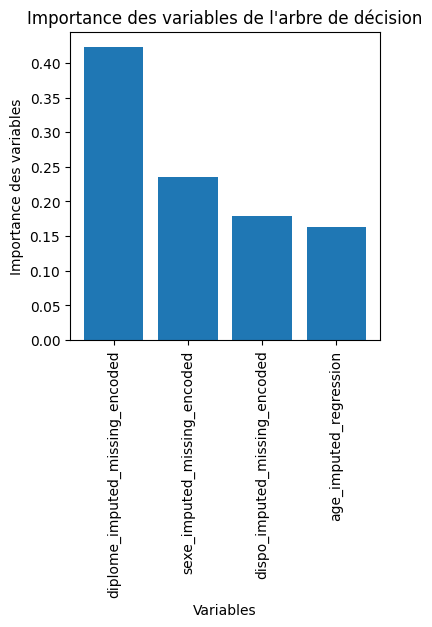

In [284]:
importance = arbre.feature_importances_
indices = np.argsort(importance)[::-1]             #Donne les indices triés par ordre décroissant d'importance des variables

#Affichage de l'importance
plt.figure(figsize=(4, 4))
plt.bar(range(X_train.shape[1]), importance[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlabel("Variables")
plt.ylabel("Importance des variables")
plt.title("Importance des variables de l'arbre de décision")    
plt.xticks(rotation=90) 
plt.show()

#### <span style="color:#EEE8AA"> Random Forest </span>

In [285]:
# Grille des hyperparamètres à explorer
param_grid = {
    'n_estimators': [50, 100],                      #Nombre d'arbres
    'max_depth': [2, 5, 10],                        #Profondeur maximale des arbres
    'max_samples': [0.2, 0.7, 1]                    #Fraction d'échantillons à utiliser pour chaque arbre (bootstrap)
               }
# Initialisation du modèle de Random Forest
rf_model = RandomForestClassifier(random_state=42)
# Recherche d'hyperparamètres avec GridSearchCV
rf_gscv = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
# Entraînement du modèle
rf_gscv.fit(X_train, y_train)
print("Meilleurs paramètres:", rf_gscv.best_params_)

Meilleurs paramètres: {'max_depth': 2, 'max_samples': 0.2, 'n_estimators': 50}


In [286]:
# Modèle avec les meilleurs hyperparamètres
foret = RandomForestClassifier(**rf_gscv.best_params_,random_state=42)
# Entrainement du modèle
foret.fit(X_train, y_train)
# Prédiction sur les valeurs de l'ensemble de test
y_pred_foret = foret.predict(X_val)

# Évaluation
print("Accuracy (Logistic Regression Lasso):", accuracy_score(y_val, y_pred_foret))
print("F1-score (Logistic Regression Lasso):", f1_score(y_val, y_pred_foret, average='weighted'))
print("ROC-AUC (Logistic Regression Lasso):", roc_auc_score(y_val, foret.predict_proba(X_val)[:, 1]))
print("\nConfusion Matrix :\n", confusion_matrix(y_val, y_pred_foret))

Accuracy (Logistic Regression Lasso): 0.8805333333333333
F1-score (Logistic Regression Lasso): 0.8245947438079032
ROC-AUC (Logistic Regression Lasso): 0.6136841443497447

Confusion Matrix :
 [[3302    0]
 [ 448    0]]


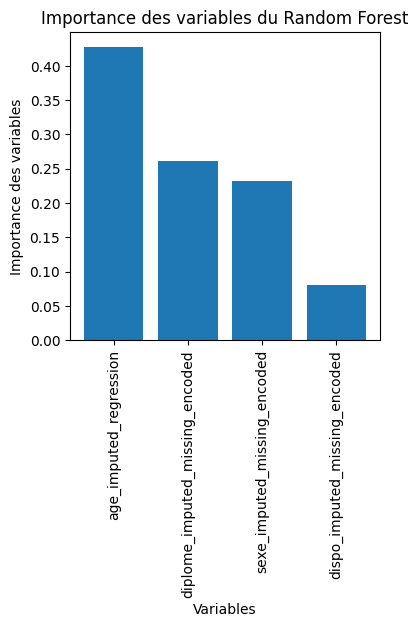

In [287]:
importance = foret.feature_importances_
indices = np.argsort(importance)[::-1]             #Donne les indices triés par ordre décroissant d'importance des variables

#Affichage de l'importance
plt.figure(figsize=(4, 4))
plt.bar(range(X_train.shape[1]), importance[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlabel("Variables")
plt.ylabel("Importance des variables")
plt.title("Importance des variables du Random Forest")    
plt.xticks(rotation=90) 
plt.show()

#### <span style="color:#EEE8AA"> XGBoost </span>

In [288]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)   

# # Grille des hyperparamètres à explorer
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }
# Initialisation du modèle de Random Forest
# xgb_model = xgb.XGBClassifier(random_state=42)
# Recherche d'hyperparamètres avec GridSearchCV
# xgb_gscv = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
# Entraînement du modèle
xgb_model.fit(X_train, y_train)
# print("Meilleurs paramètres XGB :", xgb_gscv.best_params_)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [289]:
# # Modèle avec les meilleurs hyperparamètres
# boost = xgb.XGBClassifier(**xgb_gscv.best_params_,random_state=42)
# Entrainement du modèle
xgb_model.fit(X_train, y_train)
# Prédiction sur les valeurs de l'ensemble de test
y_pred_boost = xgb_model.predict(X_val)

# Évaluation
print("Accuracy (XGBoost):", accuracy_score(y_val, y_pred_boost))
print("F1-score (XGBoost):", f1_score(y_val, y_pred_boost, average='weighted'))
print("ROC-AUC (XGBoost):", roc_auc_score(y_val, xgb_model.predict_proba(X_val)[:, 1]))
print("\nConfusion Matrix :\n", confusion_matrix(y_val, y_pred_boost))    

Accuracy (XGBoost): 0.8805333333333333
F1-score (XGBoost): 0.8245947438079032
ROC-AUC (XGBoost): 0.6402886913775201

Confusion Matrix :
 [[3302    0]
 [ 448    0]]


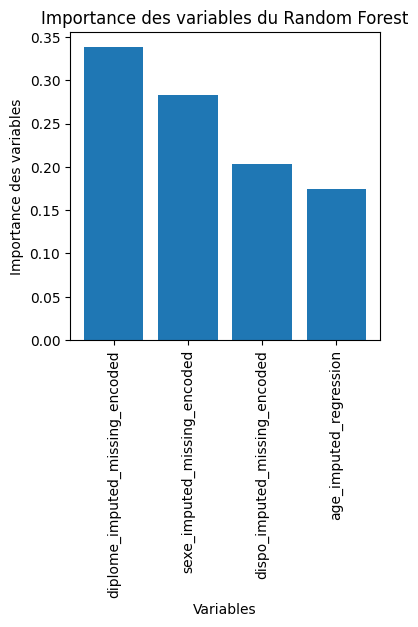

In [290]:
importance = xgb_model.feature_importances_
indices = np.argsort(importance)[::-1]             #Donne les indices triés par ordre décroissant d'importance des variables

#Affichage de l'importance
plt.figure(figsize=(4, 4))
plt.bar(range(X_train.shape[1]), importance[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlabel("Variables")
plt.ylabel("Importance des variables")
plt.title("Importance des variables du Random Forest")    
plt.xticks(rotation=90) 
plt.show()

### <span style="color:#EEE8AA"> Application à l'ensemble de test </span> 

In [249]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 5000 non-null   int64  
 1   date                               4980 non-null   object 
 2   cheveux                            4977 non-null   object 
 3   age                                4803 non-null   float64
 4   exp                                4974 non-null   float64
 5   salaire                            4979 non-null   float64
 6   sexe                               4980 non-null   object 
 7   diplome                            4970 non-null   object 
 8   specialite                         4980 non-null   object 
 9   note                               4615 non-null   float64
 10  dispo                              4980 non-null   object 
 11  age_imputed_mean                   5000 non-null   float

In [250]:
cols_to_select = X_train.columns
X_test = test[cols_to_select]

In [251]:
# A commenter ou décommenter le modèle à utiliser
best_model = xgb_model
# best_model = foret
# best_model = arbre
# best_model = log_lasso

In [252]:
y_pred_test = best_model.predict(X_test)

On enregistre le dataset

In [253]:
submission = pd.DataFrame({
    'id': test['id'],
    'embauche': y_pred_test
})
submission.to_csv('submits/submission_xgb.csv', index=False)